In [1]:
%matplotlib inline

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os  

# Load images 

In [19]:
data = []
# Loop through all .jpg files in a derectory and read them into arrays
for fn in os.listdir("./animals/"):
    if fn.endswith(".jpg"):
        data.append(plt.imread("./animals/" + fn))

In [20]:
data

[array([[[ 57,  60,   7],
         [ 57,  60,   7],
         [ 57,  60,   7],
         ...,
         [138, 148,  77],
         [138, 148,  77],
         [138, 148,  77]],
 
        [[ 57,  60,   7],
         [ 57,  60,   7],
         [ 56,  59,   6],
         ...,
         [138, 148,  77],
         [138, 148,  77],
         [138, 148,  77]],
 
        [[ 54,  58,   7],
         [ 54,  58,   7],
         [ 54,  58,   7],
         ...,
         [138, 148,  77],
         [138, 148,  77],
         [138, 148,  77]],
 
        ...,
 
        [[ 59,  62,  15],
         [ 59,  62,  15],
         [ 58,  61,  14],
         ...,
         [230, 200, 172],
         [230, 200, 174],
         [230, 200, 174]],
 
        [[ 59,  62,  15],
         [ 59,  62,  15],
         [ 59,  62,  15],
         ...,
         [230, 200, 174],
         [228, 201, 174],
         [228, 200, 176]],
 
        [[ 59,  62,  15],
         [ 59,  62,  15],
         [ 59,  62,  15],
         ...,
         [231, 201, 175],
  

# Show results

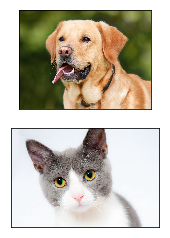

In [28]:
# Convert arrays to images and show
for i in range(len(data)):
    plt.subplot(len(data), 1, i+1)
    plt.imshow(data[i])
    plt.xticks(())
    plt.yticks(())